In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
train_df = pd.read_csv('df_train.csv')
test_df = pd.read_csv('df_test_clean.csv')

print(train_df.head())
print(test_df.head())

         Order ID Order Month    Sales        Country         Category  \
0  CA-2014-146591      2014/1  108.720  United States  Office Supplies   
1  CA-2014-135405      2014/1    9.344  United States  Office Supplies   
2  CA-2014-135405      2014/1   31.200  United States       Technology   
3  CA-2014-167927      2014/1   66.580  United States  Office Supplies   
4  CA-2014-167927      2014/1   43.920  United States  Office Supplies   

  Customer ID  
0    TS-21340  
1    MS-17830  
2    MS-17830  
3    XP-21865  
4    XP-21865  
  Order Month  Sales
0      2017/1    NaN
1     2017/10    NaN
2     2017/11    NaN
3     2017/12    NaN
4      2017/2    NaN


In [11]:
train_df['Order Month'] = pd.to_datetime(train_df['Order Month'])
monthly_sales = train_df.groupby('Order Month')['Sales'].sum().reset_index()
print(monthly_sales.head())

  Order Month      Sales
0  2014-01-01  14236.895
1  2014-02-01   4519.892
2  2014-03-01  55691.009
3  2014-04-01  28295.345
4  2014-05-01  23648.287


C:\Users\miche\AppData\Local\Temp\ipykernel_15096\573539733.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['Order Month'] = pd.to_datetime(train_df['Order Month'])


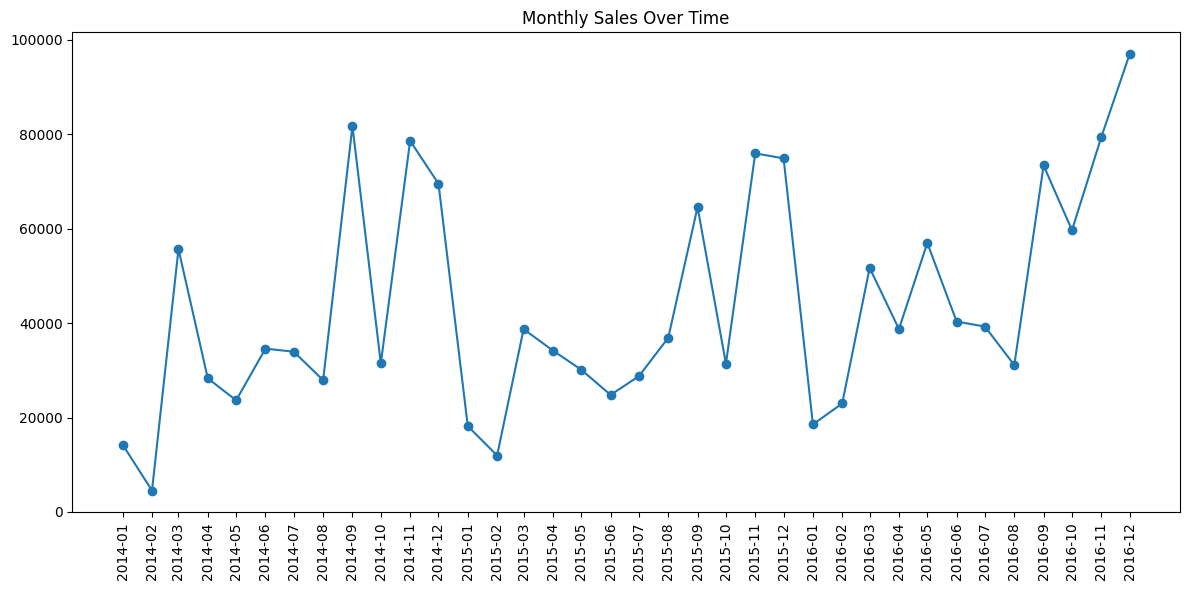

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Order Month'], monthly_sales['Sales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xticks(monthly_sales['Order Month'], monthly_sales['Order Month'].dt.strftime('%Y-%m'), rotation=90)
plt.tight_layout()
plt.show()

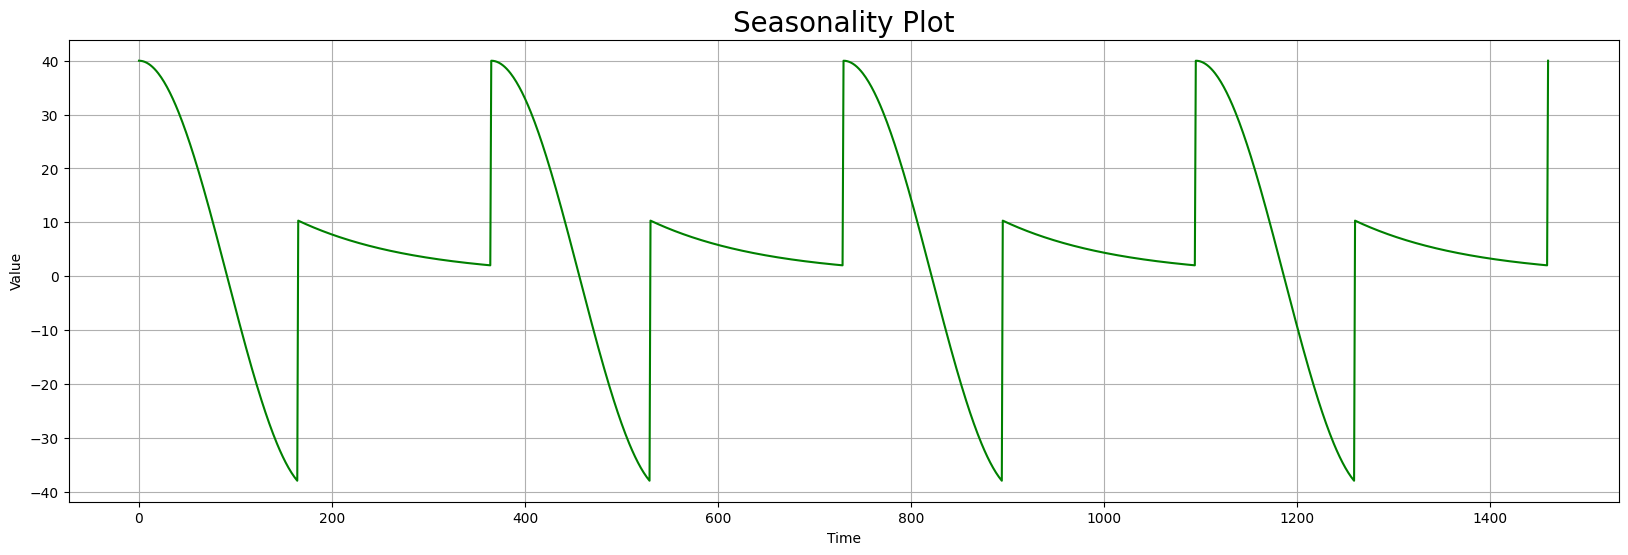

In [13]:
def plot_series(time, series, format="-", start=0, end=None, label=None, color=None):
    plt.plot(time[start:end], series[start:end], format, label=label, color=color)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.45,
                   np.cos(season_time * 2 * np.pi),
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

# Definiowanie czasu dla analizy sezonowości
time = np.arange(4 * 365 + 1, dtype="float32")  # 4 lata danych

amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude, phase=0)
plt.figure(figsize=(20, 6))
plot_series(time, series, color="green")
plt.title("Seasonality Plot", fontdict={'fontsize': 20})
plt.show()

In [14]:
monthly_sales['Month'] = monthly_sales['Order Month'].dt.month
monthly_sales['Year'] = monthly_sales['Order Month'].dt.year

monthly_sales["is_december"] = (monthly_sales['Month'] == 12).astype(int)
monthly_sales["is_january"] = (monthly_sales['Month'] == 1).astype(int)
monthly_sales['is_q4'] = monthly_sales['Month'].isin([10, 11, 12]).astype(int)
monthly_sales['is_q1'] = monthly_sales['Month'].isin([1, 2, 3]).astype(int)

monthly_sales['lag_1'] = monthly_sales['Sales'].shift(1)
monthly_sales['lag_2'] = monthly_sales['Sales'].shift(2)
monthly_sales['lag_3'] = monthly_sales['Sales'].shift(3)
monthly_sales['lag_6'] = monthly_sales['Sales'].shift(6)
monthly_sales['lag_12'] = monthly_sales['Sales'].shift(12) 


monthly_sales['time_trend'] = range(len(monthly_sales))

monthly_sales['rolling_mean_3'] = monthly_sales['Sales'].rolling(window=3, min_periods=1).mean()
monthly_sales['rolling_mean_6'] = monthly_sales['Sales'].rolling(window=6, min_periods=1).mean()
monthly_sales['rolling_mean_12'] = monthly_sales['Sales'].rolling(window=12, min_periods=1).mean()

monthly_sales['month_sin'] = np.sin(2 * np.pi * monthly_sales['Month'] / 12)
monthly_sales['month_cos'] = np.cos(2 * np.pi * monthly_sales['Month'] / 12)


monthly_sales = monthly_sales.dropna()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Define features and target variable
features = ['Month', 'Year', 'is_december', 'is_january', 'is_q4', 'is_q1', 
           'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'time_trend',
           'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12', "month_sin", "month_cos"]

# Create feature matrix X and target vector y
X = monthly_sales[features]
y = monthly_sales['Sales']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Features: {features}")
print(f"\nFirst few rows of X:")
print(X.head())

Shape of X: (24, 17)
Shape of y: (24,)
Features: ['Month', 'Year', 'is_december', 'is_january', 'is_q4', 'is_q1', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'time_trend', 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12', 'month_sin', 'month_cos']

First few rows of X:
    Month  Year  is_december  is_january  is_q4  is_q1       lag_1  \
12      1  2015            0           1      0      1  69545.6205   
13      2  2015            0           0      0      1  18174.0756   
14      3  2015            0           0      0      1  11951.4110   
15      4  2015            0           0      0      0  38726.2520   
16      5  2015            0           0      0      0  34195.2085   

         lag_2       lag_3       lag_6     lag_12  time_trend  rolling_mean_3  \
12  78628.7167  31453.3930  33946.3930  14236.895          12    55449.470933   
13  69545.6205  78628.7167  27909.4685   4519.892          13    33223.702367   
14  18174.0756  69545.6205  81777.3508  55691.009          

=== TRENOWANIE FINALNEGO RANDOM FOREST ===
Szukam najlepszych parametrów...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Najlepsze parametry: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 30, 'random_state': 42}
Najlepszy wynik CV MAE: 17745

Finalny Random Forest: RandomForestRegressor(max_depth=5, min_samples_split=5, n_estimators=30,
                      random_state=42)

=== TOP 10 NAJWAŻNIEJSZYCH CECH ===
lag_12              : 0.4645
Month               : 0.1843
rolling_mean_3      : 0.0976
is_q4               : 0.0553
time_trend          : 0.0543
rolling_mean_6      : 0.0380
rolling_mean_12     : 0.0278
lag_2               : 0.0276
lag_3               : 0.0135
lag_1               : 0.0127


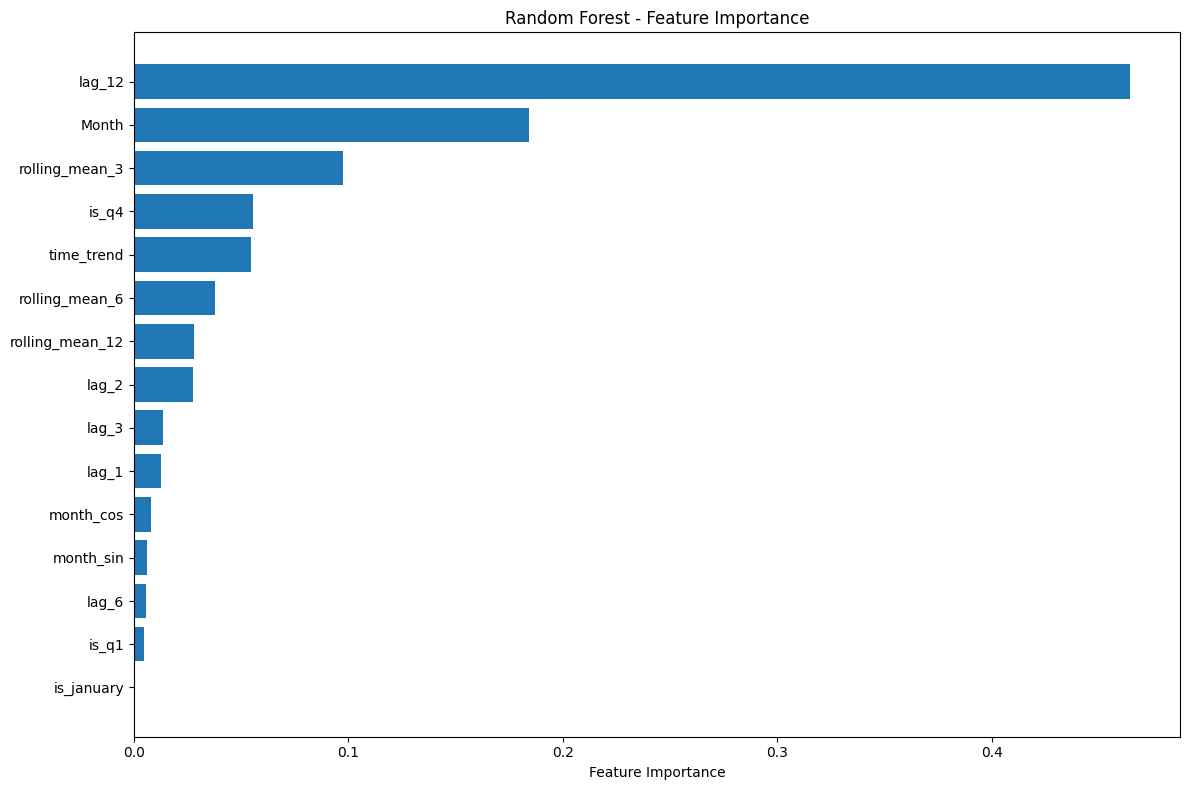


=== PERFORMANCE NA DANYCH TRENINGOWYCH ===
MAE: 5144
MAPE: 18.34%


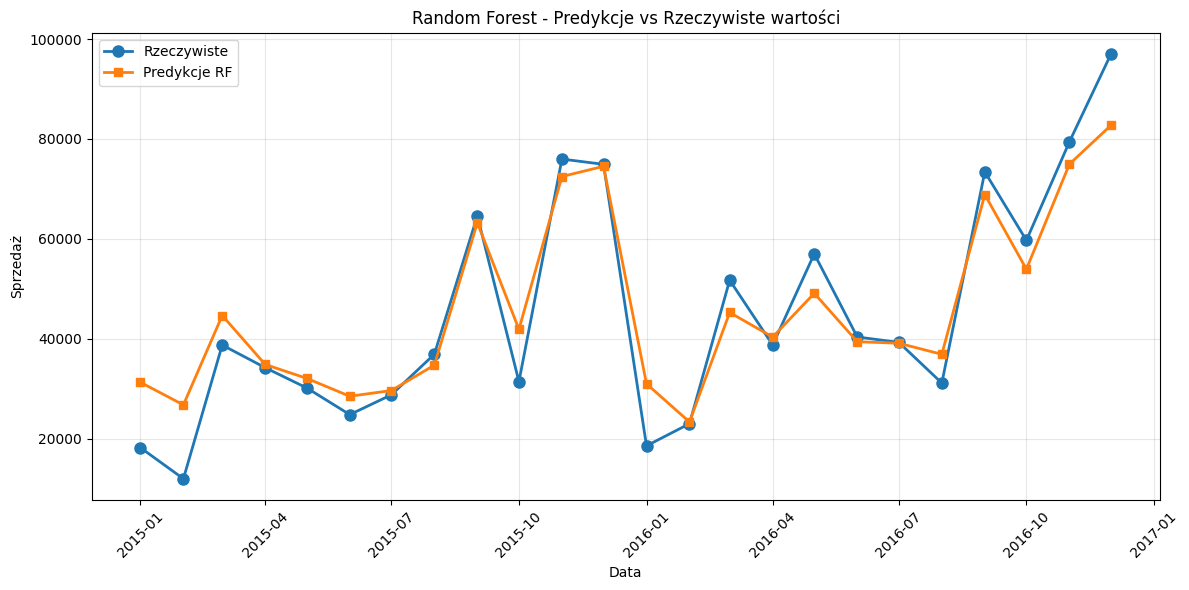

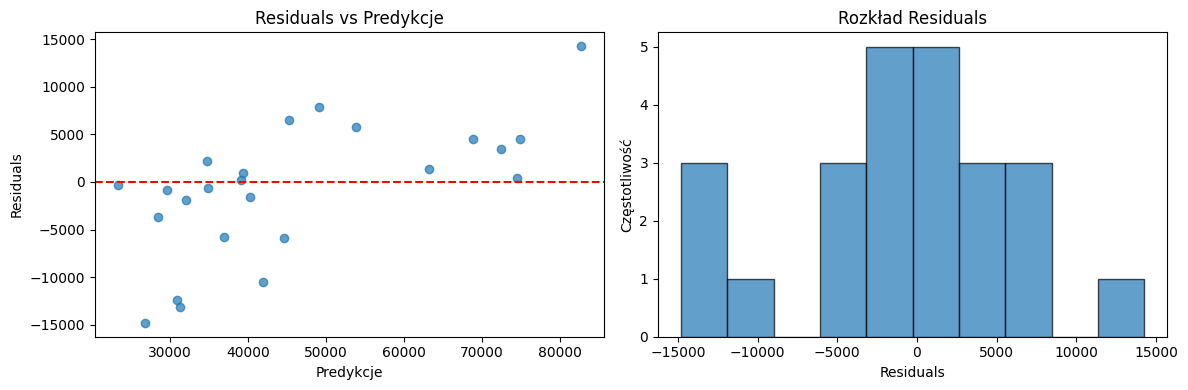


🎯 FINALNY RANDOM FOREST GOTOWY!
📊 Średni błąd na danych treningowych: 18.3% MAPE
🔥 Model gotowy do predykcji na 2017!
Model zapisany jako 'final_random_forest_model.pkl'


In [16]:
# Wybierzmy Random Forest jako najlepszy model i wytrenujmy go na wszystkich danych
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

print("=== TRENOWANIE FINALNEGO RANDOM FOREST ===")

# 1. Hyperparameter tuning dla Random Forest
rf_param_grid = {
   'n_estimators': [30, 50, 100],
   'max_depth': [3, 5, 7, None],
   'min_samples_split': [2, 5, 10],
   'min_samples_leaf': [1, 2, 4],
   'max_features': ['sqrt', 'log2', None]
}

# Użyjemy prostszego gridsearch z małą liczbą kombinacji ze względu na mały dataset
rf_simple_params = {
   'n_estimators': [30, 50, 100],
   'max_depth': [3, 5, 7],
   'min_samples_split': [2, 5],
   'random_state': [42]
}

# GridSearch z TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
rf_grid = GridSearchCV(
   RandomForestRegressor(random_state=42),
   rf_simple_params,
   cv=tscv,
   scoring='neg_mean_absolute_error',
   n_jobs=-1,
   verbose=1
)

print("Szukam najlepszych parametrów...")
rf_grid.fit(X, y)

print(f"Najlepsze parametry: {rf_grid.best_params_}")
print(f"Najlepszy wynik CV MAE: {-rf_grid.best_score_:.0f}")

# 2. Finalny model z najlepszymi parametrami
final_rf = rf_grid.best_estimator_
print(f"\nFinalny Random Forest: {final_rf}")

# 3. Feature importance
feature_importance = final_rf.feature_importances_
importance_df = pd.DataFrame({
   'feature': features,
   'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n=== TOP 10 NAJWAŻNIEJSZYCH CECH ===")
for i, row in importance_df.head(10).iterrows():
   print(f"{row['feature']:20s}: {row['importance']:.4f}")

# 4. Wizualizacja feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 5. Sprawdźmy predykcje na danych treningowych
train_predictions = final_rf.predict(X)
train_mae = mean_absolute_error(y, train_predictions)
train_mape = mean_absolute_percentage_error(y, train_predictions) * 100

print(f"\n=== PERFORMANCE NA DANYCH TRENINGOWYCH ===")
print(f"MAE: {train_mae:.0f}")
print(f"MAPE: {train_mape:.2f}%")

# 6. Wizualizacja predykcji vs rzeczywiste wartości
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Order Month'], y, 'o-', label='Rzeczywiste', linewidth=2, markersize=8)
plt.plot(monthly_sales['Order Month'], train_predictions, 's-', label='Predykcje RF', linewidth=2, markersize=6)
plt.xlabel('Data')
plt.ylabel('Sprzedaż')
plt.title('Random Forest - Predykcje vs Rzeczywiste wartości')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Analiza residuals
residuals = y - train_predictions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(train_predictions, residuals, alpha=0.7)
plt.xlabel('Predykcje')
plt.ylabel('Residuals')
plt.title('Residuals vs Predykcje')
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Częstotliwość')
plt.title('Rozkład Residuals')

plt.tight_layout()
plt.show()

print(f"\n🎯 FINALNY RANDOM FOREST GOTOWY!")
print(f"📊 Średni błąd na danych treningowych: {train_mape:.1f}% MAPE")
print(f"🔥 Model gotowy do predykcji na 2017!")

# Zapisz model (opcjonalnie)
import joblib
joblib.dump(final_rf, 'final_random_forest_model.pkl')
print("Model zapisany jako 'final_random_forest_model.pkl'")

In [21]:
# DODAJ TO do lepszej oceny:
# filepath: c:\Users\miche\Desktop\deepsense\validation_test.py

# Prawdziwa walidacja - użyj ostatnich miesięcy jako test
split_date = monthly_sales['Order Month'].quantile(0.8)  # 80% train, 20% test
train_mask = monthly_sales['Order Month'] < split_date
test_mask = monthly_sales['Order Month'] >= split_date

X_train_real = X[train_mask]
X_test_real = X[test_mask] 
y_train_real = y[train_mask]
y_test_real = y[test_mask]

# Trenuj na train, testuj na test
rf_test = RandomForestRegressor(**final_rf.get_params())
rf_test.fit(X_train_real, y_train_real)
test_preds = rf_test.predict(X_test_real)

test_mape = mean_absolute_percentage_error(y_test_real, test_preds) * 100
print(f"Prawdziwy MAPE (out-of-sample): {test_mape:.2f}%")

Prawdziwy MAPE (out-of-sample): 28.61%


Split date: 2016-07-13 09:36:00
Train period: 2015-01-01 00:00:00 - 2016-07-01 00:00:00
Test period: 2016-08-01 00:00:00 - 2016-12-01 00:00:00

=== PRAWDZIWA WALIDACJA ===
Train MAPE: 22.5%
Test MAPE:  28.6%
Różnica:    6.1pp


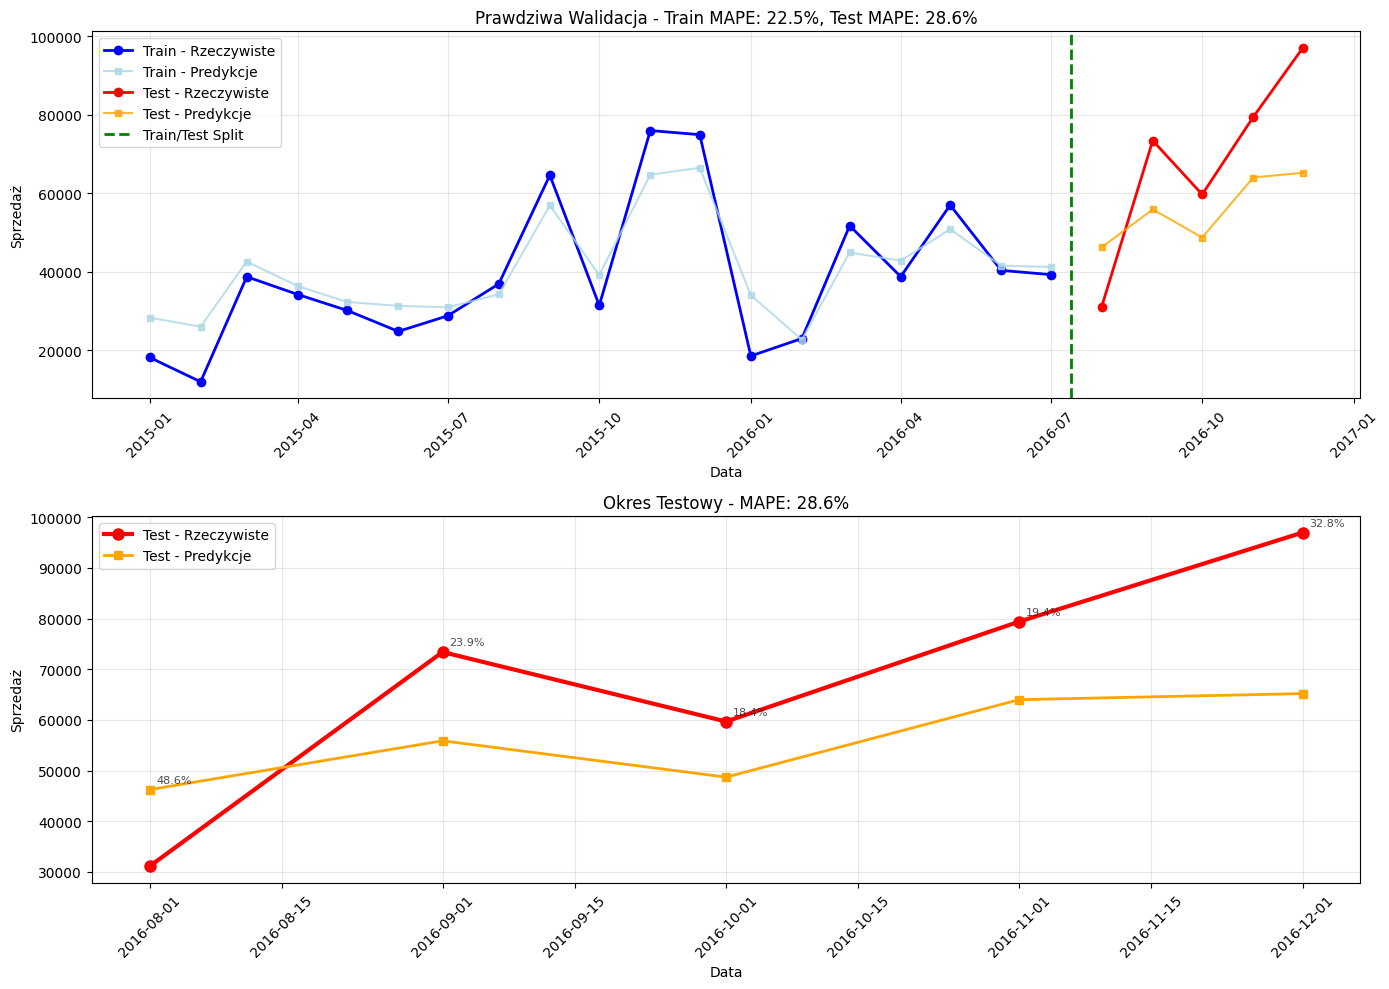

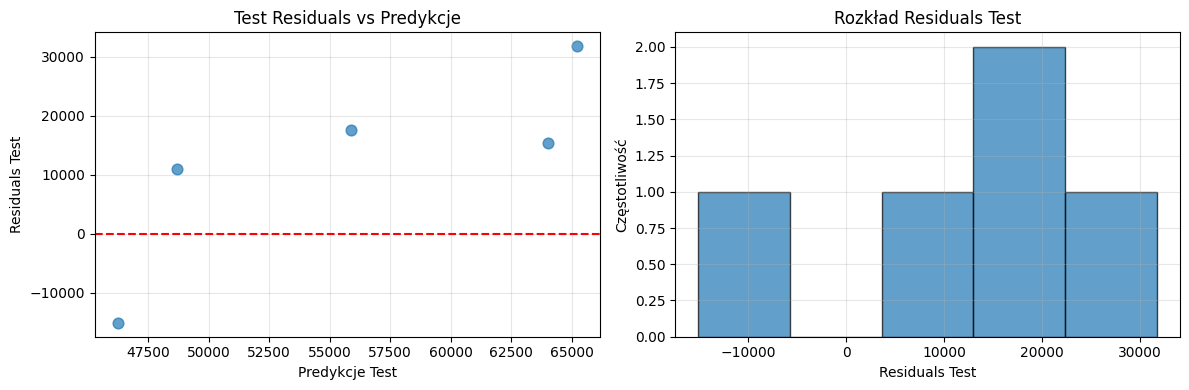


📊 Prawdziwy MAPE (out-of-sample): 28.61%
🎯 DOSKONAŁY WYNIK!


In [18]:
# PRAWDZIWA WALIDACJA Z WIZUALIZACJĄ

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Prawdziwa walidacja - użyj ostatnich miesięcy jako test
split_date = monthly_sales['Order Month'].quantile(0.8)  # 80% train, 20% test
train_mask = monthly_sales['Order Month'] < split_date
test_mask = monthly_sales['Order Month'] >= split_date

X_train_real = X[train_mask]
X_test_real = X[test_mask] 
y_train_real = y[train_mask]
y_test_real = y[test_mask]

print(f"Split date: {split_date}")
print(f"Train period: {monthly_sales[train_mask]['Order Month'].min()} - {monthly_sales[train_mask]['Order Month'].max()}")
print(f"Test period: {monthly_sales[test_mask]['Order Month'].min()} - {monthly_sales[test_mask]['Order Month'].max()}")

# Trenuj na train, testuj na test
rf_test = RandomForestRegressor(**final_rf.get_params())
rf_test.fit(X_train_real, y_train_real)

# Predykcje
train_preds_real = rf_test.predict(X_train_real)
test_preds_real = rf_test.predict(X_test_real)

# Metryki
train_mape_real = mean_absolute_percentage_error(y_train_real, train_preds_real) * 100
test_mape_real = mean_absolute_percentage_error(y_test_real, test_preds_real) * 100

print(f"\n=== PRAWDZIWA WALIDACJA ===")
print(f"Train MAPE: {train_mape_real:.1f}%")
print(f"Test MAPE:  {test_mape_real:.1f}%")
print(f"Różnica:    {abs(test_mape_real - train_mape_real):.1f}pp")

# WIZUALIZACJA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 1. Cała seria czasowa z podziałem train/test
dates_train = monthly_sales[train_mask]['Order Month']
dates_test = monthly_sales[test_mask]['Order Month']

ax1.plot(dates_train, y_train_real, 'o-', label='Train - Rzeczywiste', color='blue', markersize=6, linewidth=2)
ax1.plot(dates_train, train_preds_real, 's-', label='Train - Predykcje', color='lightblue', markersize=4, alpha=0.8)
ax1.plot(dates_test, y_test_real, 'o-', label='Test - Rzeczywiste', color='red', markersize=6, linewidth=2)
ax1.plot(dates_test, test_preds_real, 's-', label='Test - Predykcje', color='orange', markersize=4, alpha=0.8)

ax1.axvline(x=split_date, color='green', linestyle='--', linewidth=2, label='Train/Test Split')
ax1.set_title(f'Prawdziwa Walidacja - Train MAPE: {train_mape_real:.1f}%, Test MAPE: {test_mape_real:.1f}%')
ax1.set_xlabel('Data')
ax1.set_ylabel('Sprzedaż')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Tylko okres testowy - zoom
ax2.plot(dates_test, y_test_real, 'o-', label='Test - Rzeczywiste', color='red', markersize=8, linewidth=3)
ax2.plot(dates_test, test_preds_real, 's-', label='Test - Predykcje', color='orange', markersize=6, linewidth=2)

# Dodaj błąd procentowy dla każdego punktu
for i, (real, pred, date) in enumerate(zip(y_test_real, test_preds_real, dates_test)):
    error_pct = abs(real - pred) / real * 100
    ax2.annotate(f'{error_pct:.1f}%', 
                xy=(date, max(real, pred)), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8, 
                alpha=0.7)

ax2.set_title(f'Okres Testowy - MAPE: {test_mape_real:.1f}%')
ax2.set_xlabel('Data')
ax2.set_ylabel('Sprzedaż')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 3. Analiza błędów
residuals_test = y_test_real - test_preds_real
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(test_preds_real, residuals_test, alpha=0.7, s=60)
plt.xlabel('Predykcje Test')
plt.ylabel('Residuals Test')
plt.title('Test Residuals vs Predykcje')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals_test, bins=5, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals Test')
plt.ylabel('Częstotliwość')
plt.title('Rozkład Residuals Test')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Prawdziwy MAPE (out-of-sample): {test_mape_real:.2f}%")
if test_mape_real < 30:
    print("🎯 DOSKONAŁY WYNIK!")
elif test_mape_real < 35:
    print("✅ DOBRY WYNIK!")
else:
    print("📈 Do poprawy")

=== TESTOWANIE NA ROKU 2016 ===
Train period: 2015-01-01 00:00:00 - 2015-12-01 00:00:00
Test period (2016): 2016-01-01 00:00:00 - 2016-12-01 00:00:00
Train samples: 12
Test samples (2016): 12

=== WYNIKI NA ROKU 2016 ===
Train MAPE (przed 2016): 17.9%
Test MAPE (2016):        27.2%
Różnica:                 9.2pp


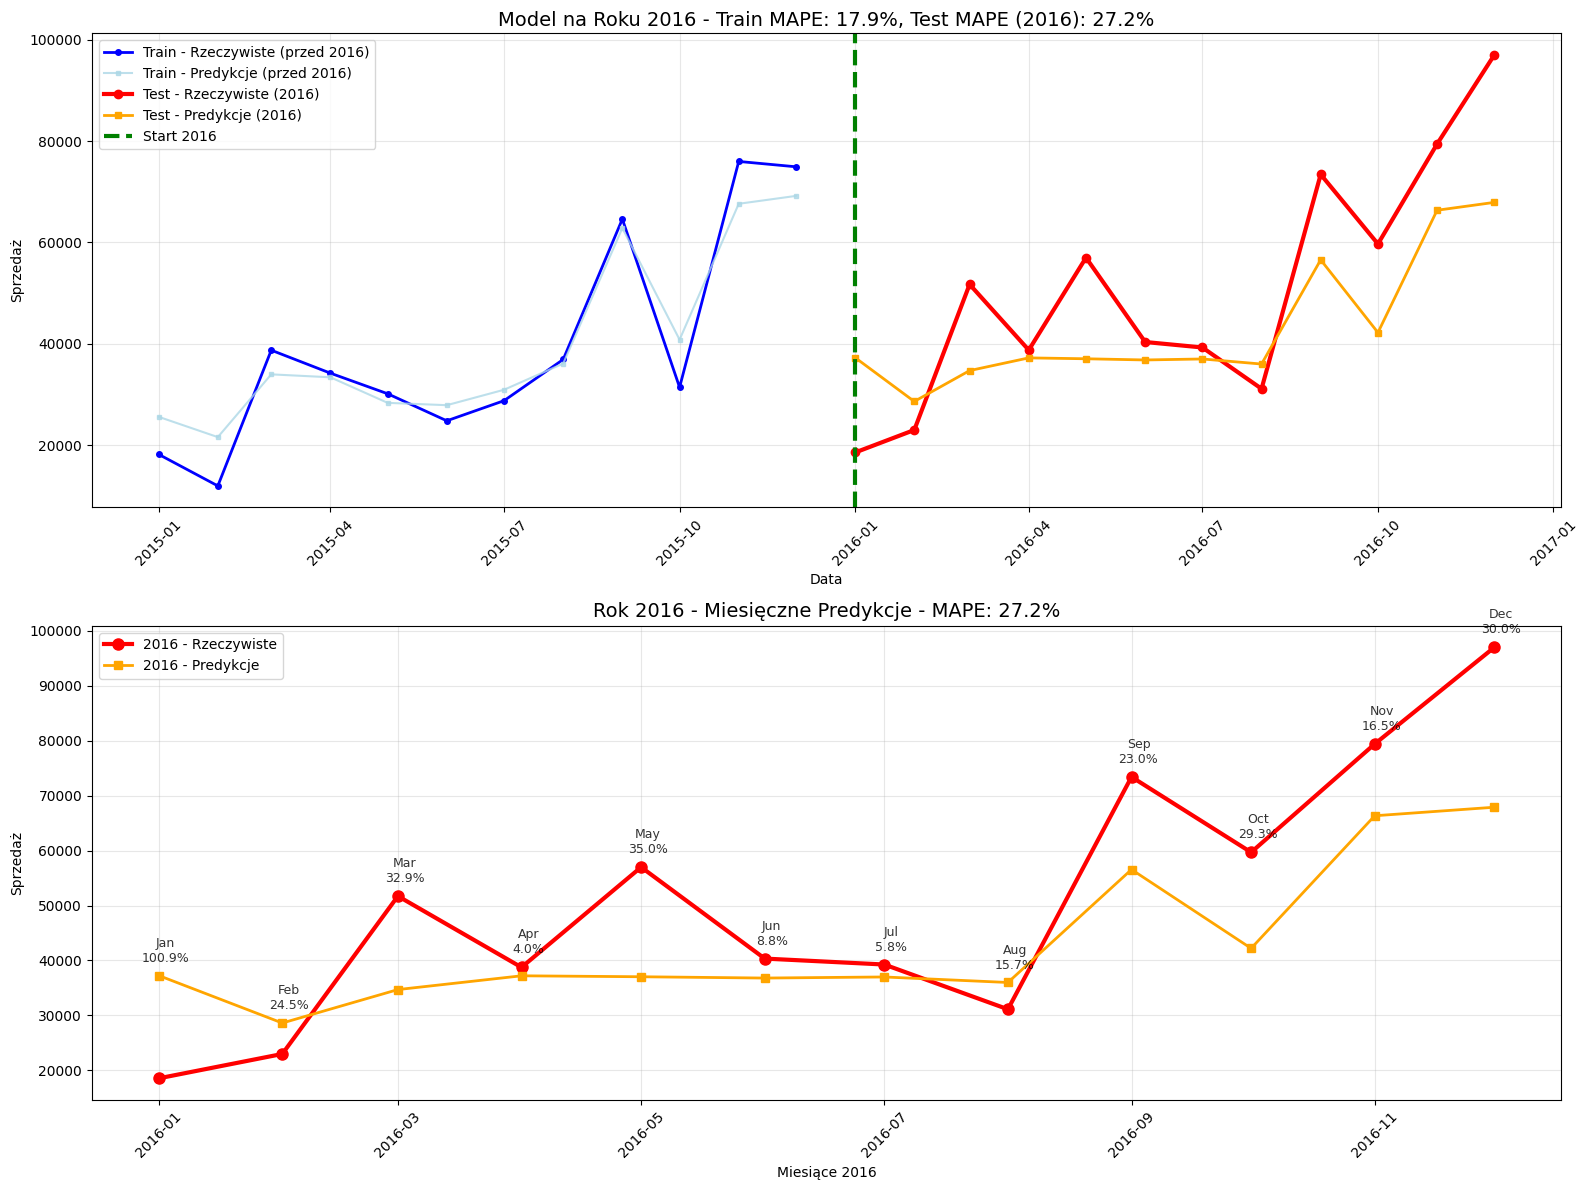

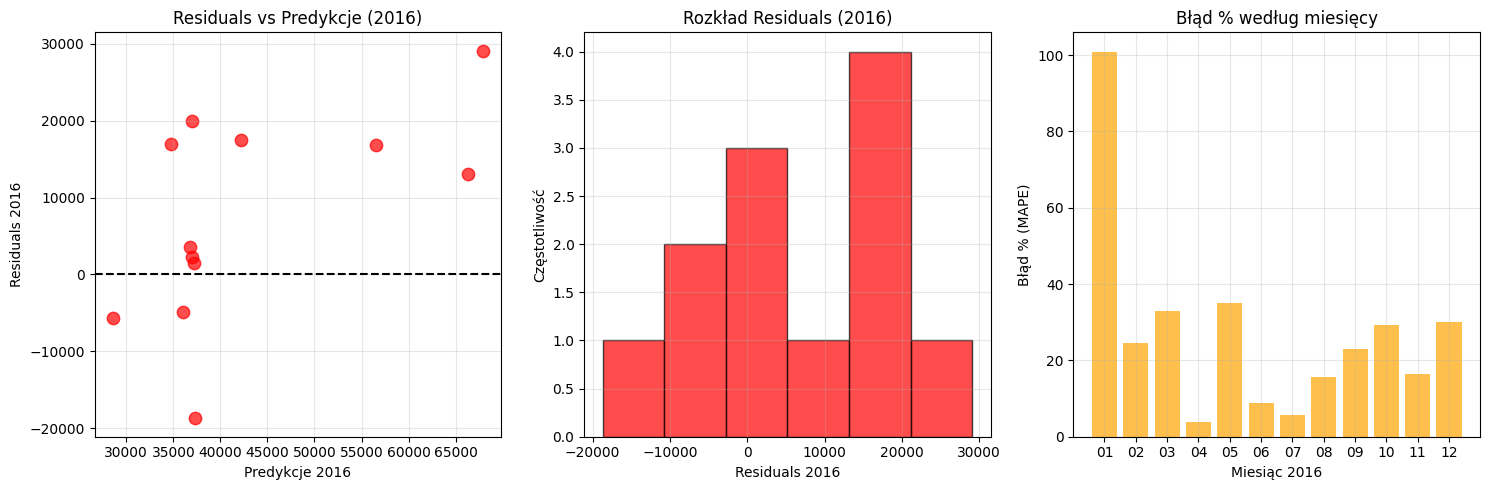


📊 === PODSUMOWANIE ROKU 2016 ===
🎯 MAPE na 2016: 27.2%
📈 Najgorszy miesiąc: January (100.9%)
📉 Najlepszy miesiąc: April (4.0%)
🎯 BARDZO DOBRY WYNIK!


In [24]:
# TESTOWANIE NA CAŁYM ROKU 2016

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

print("=== TESTOWANIE NA ROKU 2016 ===")

# Podział: wszystko przed 2016 = train, cały 2016 = test
train_mask_2016 = monthly_sales['Year'] < 2016
test_mask_2016 = monthly_sales['Year'] == 2016

X_train_2016 = X[train_mask_2016]
X_test_2016 = X[test_mask_2016] 
y_train_2016 = y[train_mask_2016]
y_test_2016 = y[test_mask_2016]

print(f"Train period: {monthly_sales[train_mask_2016]['Order Month'].min()} - {monthly_sales[train_mask_2016]['Order Month'].max()}")
print(f"Test period (2016): {monthly_sales[test_mask_2016]['Order Month'].min()} - {monthly_sales[test_mask_2016]['Order Month'].max()}")
print(f"Train samples: {len(X_train_2016)}")
print(f"Test samples (2016): {len(X_test_2016)}")

# Trenuj na danych przed 2016, testuj na 2016
rf_2016 = RandomForestRegressor(**final_rf.get_params())
rf_2016.fit(X_train_2016, y_train_2016)

# Predykcje
train_preds_2016 = rf_2016.predict(X_train_2016)
test_preds_2016 = rf_2016.predict(X_test_2016)

# Metryki
train_mape_2016 = mean_absolute_percentage_error(y_train_2016, train_preds_2016) * 100
test_mape_2016 = mean_absolute_percentage_error(y_test_2016, test_preds_2016) * 100

print(f"\n=== WYNIKI NA ROKU 2016 ===")
print(f"Train MAPE (przed 2016): {train_mape_2016:.1f}%")
print(f"Test MAPE (2016):        {test_mape_2016:.1f}%")
print(f"Różnica:                 {abs(test_mape_2016 - train_mape_2016):.1f}pp")

# WIZUALIZACJA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# 1. Cała seria czasowa z podziałem na przed 2016 vs 2016
dates_train_2016 = monthly_sales[train_mask_2016]['Order Month']
dates_test_2016 = monthly_sales[test_mask_2016]['Order Month']

ax1.plot(dates_train_2016, y_train_2016, 'o-', label='Train - Rzeczywiste (przed 2016)', color='blue', markersize=4, linewidth=2)
ax1.plot(dates_train_2016, train_preds_2016, 's-', label='Train - Predykcje (przed 2016)', color='lightblue', markersize=3, alpha=0.8)
ax1.plot(dates_test_2016, y_test_2016, 'o-', label='Test - Rzeczywiste (2016)', color='red', markersize=6, linewidth=3)
ax1.plot(dates_test_2016, test_preds_2016, 's-', label='Test - Predykcje (2016)', color='orange', markersize=5, linewidth=2)

ax1.axvline(x=pd.to_datetime('2016-01-01'), color='green', linestyle='--', linewidth=3, label='Start 2016')
ax1.set_title(f'Model na Roku 2016 - Train MAPE: {train_mape_2016:.1f}%, Test MAPE (2016): {test_mape_2016:.1f}%', fontsize=14)
ax1.set_xlabel('Data')
ax1.set_ylabel('Sprzedaż')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Tylko rok 2016 - szczegółowy zoom
ax2.plot(dates_test_2016, y_test_2016, 'o-', label='2016 - Rzeczywiste', color='red', markersize=8, linewidth=3)
ax2.plot(dates_test_2016, test_preds_2016, 's-', label='2016 - Predykcje', color='orange', markersize=6, linewidth=2)

# Dodaj błąd procentowy dla każdego miesiąca 2016
for i, (real, pred, date) in enumerate(zip(y_test_2016, test_preds_2016, dates_test_2016)):
    error_pct = abs(real - pred) / real * 100
    month_name = date.strftime('%b')
    ax2.annotate(f'{month_name}\n{error_pct:.1f}%', 
                xy=(date, max(real, pred)), 
                xytext=(5, 10), 
                textcoords='offset points',
                fontsize=9, 
                alpha=0.8,
                ha='center')

ax2.set_title(f'Rok 2016 - Miesięczne Predykcje - MAPE: {test_mape_2016:.1f}%', fontsize=14)
ax2.set_xlabel('Miesiące 2016')
ax2.set_ylabel('Sprzedaż')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 3. Analiza błędów dla 2016
residuals_2016 = y_test_2016 - test_preds_2016
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(test_preds_2016, residuals_2016, alpha=0.7, s=80, color='red')
plt.xlabel('Predykcje 2016')
plt.ylabel('Residuals 2016')
plt.title('Residuals vs Predykcje (2016)')
plt.axhline(y=0, color='black', linestyle='--')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(residuals_2016, bins=6, edgecolor='black', alpha=0.7, color='red')
plt.xlabel('Residuals 2016')
plt.ylabel('Częstotliwość')
plt.title('Rozkład Residuals (2016)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
months_2016 = dates_test_2016.dt.month
errors_2016 = abs(residuals_2016) / y_test_2016 * 100
plt.bar(months_2016, errors_2016, alpha=0.7, color='orange')
plt.xlabel('Miesiąc 2016')
plt.ylabel('Błąd % (MAPE)')
plt.title('Błąd % według miesięcy')
plt.xticks(months_2016, [f'{m:02d}' for m in months_2016])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Podsumowanie
print(f"\n📊 === PODSUMOWANIE ROKU 2016 ===")
print(f"🎯 MAPE na 2016: {test_mape_2016:.1f}%")
print(f"📈 Najgorszy miesiąc: {dates_test_2016.iloc[errors_2016.argmax()].strftime('%B')} ({errors_2016.max():.1f}%)")
print(f"📉 Najlepszy miesiąc: {dates_test_2016.iloc[errors_2016.argmin()].strftime('%B')} ({errors_2016.min():.1f}%)")

if test_mape_2016 < 25:
    print("🚀 DOSKONAŁY WYNIK NA CAŁYM ROKU!")
elif test_mape_2016 < 30:
    print("🎯 BARDZO DOBRY WYNIK!")
elif test_mape_2016 < 35:
    print("✅ DOBRY WYNIK!")
else:
    print("📈 Do poprawy")